###############################################################################
###############################################################################
#### Water storage model                                                   ####
#### Timothy Tiggeloven                                                    ####
#### Water_Risk_prac.py                                                    ####
#### Python 3.6.0                                                          ####
####                                                                       ####
#### Analyses different Water harvesting systems                           ####
###############################################################################
###############################################################################




In this practicum Python is used to run the water storage model. Both Python 2.7 and 3+ can be used to run the script if it includes the “Pandas” package to manipulate data frames. If Pandas is not included Python will return an “Import Error”. Make sure the Pandas package is properly installed. By default it is installed with Anaconda and you can check it in environments in the Anaconda Navigator.
During this practicum we will focus on basic time series analysis and list operations in Python. While programming, you will come across errors in your script. Try first to read the errors and understand what went wrong. A lot of the times it’s just a typo. When you are in doubt about the error, it might help to google the error message and maybe add the function you used to narrow the searches down. A very helpful site that will pop up in google is stackoverflow in which similar problems are solved by the stackoverflow community.
For this exercise, imagine you live in Ethiopia or other assigned country in Africa and have a household to run. You need 85.86 liters of water per week per person for your household. You want to implement water harvesting technique and want to know the effect of climate change on your investment. You want to know if your investment is feasible. In order to calculate this you have a water storage model and meteorological timeseries at your disposal. The water storage model is a simple model in which water can be harvested and stored during a period of time. The model runs on a daily time step basis in which water enters the system through direct precipitation or runoff and leaves the system through usage of water and evaporation. Two types of water harvesting structures (WHS) will be used in this practical; cistern and open pond. Dimensions and usage can be altered in the script. For cistern storage evaporation is assumed to be zero, however it is more expensive to build (Lasage & Verburg, 2015). The model takes input of comma-separated values (csv) files in which data of the years, months, days, precipitation and temperature of the specified region is found. The following paragraphs are a guide to the script. First have a look at the script and start with the assignments after.

In [32]:
# read modules
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
%matplotlib inline


Part I: Load input and declare variables
========================================

In this step we are going read some input variables with package called Pandas /n
Further we assign values to declare the charaxcteristics of th WHS
And we specify the region of interest

<br>

Make sure the input files and the python script are in the same folder. Reading csv files is done with the pandas read_csv function. Be sure to specify the right csv file as input file and assign a suitable name for the output file when you make adjustments to the variables.
The global variables assign the water usage, runoff coefficient, threshold and latitude in degrees of selected region (be sure to update the latitude when switching input files). Next, the specific variables for the WHS are assigned. Experiment with these values to get the maximum efficiency.

Before running the script, select the correct ‘historical’ input file, that is not with ‘rcp’ in the name (you will be assigned a geographical location to analyze in this practical).

In [3]:
# Assign input and output file.
input_file = "input_rcp4p5_2036_malawi_mulanje_region.csv"
output_file = "output_###.csv"

In [5]:
# read input, store data from dataframe to list
try:
    df = pd.read_csv(input_file)
except FileNotFoundError as e:
    print("\nFileNotFoundError: %s" % e)
    print("\nCheck input file name\n")
    sys.exit(1)

data = df[['Year', 'Month', 'Day', 'Precipitation', 'Temperature']].copy()

data['Time'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
Time = data['Time'].values.flatten()
data['Day of year'] = data['Time'].dt.dayofyear
data = data.set_index('Time')

Define the size of the reservoirs for open pond and cistern.

In [6]:
# global variables
demand = 85.86                 # demand of water per week per person [L]
HH = 5.8                       # mean persons per household in Ethiopia
num = 10                       # number of households that use open pond
ROC = 0.58                     # runoff coefficient [-]
threshold = 0.01               # minimum rainfall before runoff occurs [m3]
lat = -1.1315313               # latitude of location [•]

In [7]:
# cistern variables
cap_cis = 50                   # capacity of cistern [m3]
catchment_cis = 300            # catchment size of cistern [m2]
depth_cis = 2                  # depth of cistern [m]
inlet_cis = cap_cis/depth_cis  # inlet of cistern [m2]
storage_cis = 0                # set initial storage of cistern [m3]

In [8]:
# open pond variables
cap_op = 50                    # capacity of open pond [m3]
catchment_op = 300             # catchment size of open pond [m2]
depth_op = 2                   # depth of open pond [m]
inlet_op = cap_op/depth_op     # inlet of open pond [m2]
storage_op = 0                 # set initial storage of open pond [m3]

Part II: Functions
==================

The model makes use of two functions, namely the storage calculation and evaporation function. Thornthwaite evaporation is calculated with the evap_calc function (line 81) and takes temperature, number of the day of the year, number of the day of the month, month number and year as input. Because the Thornthwaite evaporation is dependent on the average length of the day and a heat function based on mean monthly temperatures extra sets of codes are used. The Thornthwaite evaporation is calculated with the following formula:
<br>
$$PE=16* L (10Ta)α 12*M I$$
<br>
, where L is the average length of the day, M the number of days in the month, T a the average daily temperature, I the heat index and α a function based on the heat index (Thornthwaite, 1948). Potential evaporation ( P E ) is calculated in mm day-​ 1​. Lines 83-86 uses the sunrise equation in order to calculate the average length of the day (Allen et al., 1998). To calculate the average temperature per month line 90 is used. Lines 90-93 calculates the number of days of the month based on the year and month number. The heat index function, which depends on the 12 monthly mean temperature is calculated to daily data in lines 95-101. Finally, the alpha function and Thornthwaite evaporation can be calculated with lines 109-110 and 112-119 respectively. If daily average temperature is higher than 26 a different equation is used (line 114) and if temperature is below zero evaporation is assumed to be close to zero (line 116).
The storage calculation function takes precipitation, Thornthwaite evaporation and descriptions of the WHS as input. Potential daily water harvesting is assigned with usage in line 126. Evaporation is assigned zero for cistern storage and Thornthwaite values for open pond (for example you can also add the Penman-Monteith evaporation in a function and assign them here). A ValueError will be raised if WHS system is neither cistern nor open pond (see line 130 and 132). The storage calculation is done within a loop through the lists of evaporation and precipitation values (line 140). Evaporation and precipitation is divided by 1000 to transform mm day-​ 1 to m day-​ 1​. Direct precipitation is only assigned if WHS is open pond (lines 144-146). Runoff only takes place if the assigned threshold is met and calculated by multiplying the catchment size with precipitation and the runoff coefficient. Evaporation is multiplied with the inlet of the WHS and subtracted of the storage. The list E_list keeps track of the amount of storage water evaporated during the period of the model run. If potential evaporation is higher than the amount of water in WHS, actual evaporation will be lower than potential, hence line 152-158. To check whether the storage will not succeed capacity or be a negative value, and to calculate the amount of water that can be harvested the lines 160-171 of code has been implemented. Water storage calculations are done in the following order: inflow through runoff and direct precipitation, outgoing flux of evaporation and, subsequently, extraction for household use.

In [10]:
# creates an object to store variables in
class Storage_output(object):

    def __init__(self, storage, usage, evaporation):
        self.storage = storage
        self.usage = usage
        self.evaporation = evaporation

In [11]:
def evap_calc(data):
    # calculate photoperiod
    omega = lat * math.pi / 180
    data['Delta'] = 0.409 * np.sin(2 * data['Day of year'] * np.pi / 365 - 1.39)
    data['ws'] = np.arccos(-np.tan(omega) * np.tan(data['Delta']))
    data['daylight'] = 24 * data['ws'] / np.pi
    data = data.drop(['Delta', 'ws'], axis=1)

    # average temperature data per month
    Month_data = data['Temperature'].resample("M").mean().to_frame()

    # assign number of days in a month for the specific months in data        
    data['days per month'] = data.index.to_series().dt.daysinmonth

    # calculate heat index per year 
    Month_data['Heat index'] = pow((0.2 * Month_data['Temperature']), 1.514)
    Year_data = Month_data['Heat index'].resample("A").sum().to_frame()
    
    # convert monthly HI to daily
    Year_data['Year'] = Year_data.index.to_series().dt.year
    data = data.merge(Year_data, how='left', on='Year')

    TW = []
    for i, j, k, l in zip(data['Temperature'].values.flatten(),
                          data['daylight'].values.flatten(),
                          data['days per month'].values.flatten(),
                          data['Heat index'].values.flatten()):
        # calculate function depended on heat index
        alpha = ((6.75 * pow(10, -7)) * pow(l, 3) - (7.71 * pow(10, -5)) *
                 pow(l, 2) + (1.7912 * pow(10, -2)) * l + 0.49239)

        # check if temperature is below zero or higher than 26 •C
        if i > 26:
            z = (j / (12 * k)) * (-415.85 + 32.24 * i - pow((0.43 * i), 2))
        elif i < 0:
            z = 0.0001
        else:
            z = 16 * (j / (12 * k)) * pow((10 * i / l), alpha)
        TW.append(z)
    
    return TW

Below there is a fucntion which calculates the storage amount based on the precipitation, evaporation and water use  <br> check

In [13]:
def storage_calc(prec, TW, WHS, cap, catchment, depth, inlet, storage):
    """
    
    """
    # calculate potential usage of WHS in m^3
    potential_usage = (HH * num) * (demand / 7) / 1000

    # assign evaporation with Thornthwaite equation
    evap = []
    if WHS == 'cistern':
        evap = [0 * i for i in TW]
    elif WHS == 'open pond':
        evap = TW
    else:
        raise ValueError('WHS should be either "cistern" or "open pond"')

    E_list = []
    store_list, usage_list = [], []
    # calculate storage and usage of WHS
    for i, j in zip(evap, prec):
        E = i / 1000
        pr = j / 1000

        # channel precipitation for open pond
        if WHS == 'open pond':
            storage += inlet * pr

        # runoff
        if pr > threshold:
            storage += catchment * pr * ROC

        # evaporation
        E = E * inlet
        if storage < E:
            E_list.append(storage)
        else:
            E_list.append(E)
        storage -= E

        # check capacity, depletion and usage
        if storage > cap:
            storage = cap - potential_usage
            extract = potential_usage
        elif storage < 0:
            storage, extract = 0, 0
        elif storage < potential_usage:
            extract = storage
            storage = 0
        else:
            storage -= potential_usage
            extract = potential_usage

        store_list.append(storage), usage_list.append(extract)

    output = Storage_output(store_list, usage_list, E_list)

    return output

Part III: Calculations
======================

First we are going to run the functions to et the data. With the evap calc function, we calculate the evaporation, with ...
<br>

In Part III functions are called and data is passed to the functions. Because the storage function returns an ‘object’ (called in line 175 and assigned in storage_output class in lines 72-78); storage, usage and evaporation can easily be called with for example output_op.usage for open pond usage. Calculations are done to check, for example, the evaporative fracture by dividing the total evaporation by the
  2
capacity of the WHS. The effectiveness of the WHS can be calculated by dividing the total water demand over the analyzed period into the actual extracted water from the reservoir for household use. Results of calculations can be printed in the Python shell with the print() function. Next, data about the run is passed in lists and stored in Pandas dataframe (lines 235-264).

In [15]:
evap_TW = evap_calc(data)
data['TW'] = evap_TW
prec_data = data['Precipitation'].values.flatten()

output_cis = storage_calc(prec_data, evap_TW, "cistern", cap_cis,
                          catchment_cis, depth_cis, inlet_cis, storage_cis)
output_op = storage_calc(prec_data, evap_TW, "open pond", cap_op, catchment_op,
                         depth_op, inlet_op, storage_op)

In [18]:
# calculate usage
potential_usage = (HH * num) * (demand / 7) / 1000
potential_usage

0.7114114285714286

In [20]:
# total evaporation and evaporative fracture
total_evap_op = np.sum(output_op.evaporation)
print('Total evaporation of open pond: %s' % total_evap_op)

1183.9866254462047

In [21]:
EF_op = total_evap_op / cap_op
print('Potential evaporative fracture of open pond: %s' % EF_op)

23.679732508924094

# Calculate yearly extracted water and effectiveness
Add script to calculate the average yearly extracted water and effectiveness. (Hint: use the
list of output_op.usage for open pond usage)

In [24]:
# write here your code
YE_op = np.sum(output_op.usage) / len(output_op.usage) * 365
YE_cis = np.sum(output_cis.usage) / len(output_cis.usage) * 365
effect_op = np.sum(output_op.usage) / (len(output_op.usage) * potential_usage)
effect_cis = np.sum(output_cis.usage) / (len(output_cis.usage) * potential_usage)
print('\nYearly extracted water of open pond: %s' % YE_op)
print('Yearly extracted water of cistern: %s' % YE_cis)
print('\nEffectiveness of open pond: %s' % effect_op)
print('Effectiveness of cistern: %s' % effect_cis)

text 103.14771199056786


# Calculate costs of construction and costs per qubic meter harvested water
The investment costs per m3​ of storage capacity for an open pond is $20.47 dollar, and for a
cistern $32.28. Calculate in the script the total investment costs and costs per m3​ of
extracted water.

In [25]:
# write here your code
costs_op = 20.47 * cap_op
costs_cis = 32.28 * cap_cis
costs_water_op = costs_op / np.sum(output_op.usage)
costs_water_cis = costs_cis / np.sum(output_cis.usage)
print('\nInvestment costs for open pond: %s' % costs_op)
print('Investment costs for cistern: %s' % costs_cis)
print('\nCost of water per qubic meter for open pond: %s' % costs_water_op)
print('Cost of water per qubic meter for cistern: %s' % costs_water_cis)

text 103.14771199056786


# Calculate the numnber of dry days for each WHS

Line 195 calculates the daily water use of the households. Calculate the total number of
days the reservoir contains too little water to meet this water use. In other words we need to iterate over a list and count if condition is met. (Hint: use np.where function or make use of a loop)

In [26]:
# write here your code

# dry days open pond
dry_days_op = 0
for i in output_op.usage:
    if i < potential_usage:
        dry_days_op += 1

# dry days cistern
dry_days_cis = 0
for i in output_cis.usage:
    if i < potential_usage:
        dry_days_cis += 1
        
print('\nCount of days of depleted water storage open pond: %s' % dry_days_op)
print('Count of days of depleted water storage cistern: %s' % dry_days_cis)

Part IV: Saving data to csv
===========================
Output is written to a csv file. Lines 277-323 consists of lines of codes in which precipitation is plotted with the water storage of the WHS. Plotting data can be done by uncommenting line 326 (remove #). Loading might take a while as there are more than 10.000 data points.
<br>
The goal is to make a graph with the investment per m3​ of extracted water for your location in relation to the percentage of the year water is available in the system on average for the whole analyzed period. This can either be done by adding script to the program (adding more instances of storage_calc() with different input values), or by using the output files in, for example, Excel. At the bottom of this document several functions are listed which you can use to add to the program.

In [28]:
# Make empty lists and store information of the model run and global variables
GV_meta = [None] * len(Time)
GV_data = list(GV_meta)

GV_meta[0:24] = ["Cap cis", "Cap op", "Catchment cis", "Catchment op",
                 "Depth cis", "Depth op", "Inlet cis", "Inlet op",
                 "Initial storage cis", "Initial storage op",
                 "Effectiveness cis", "Effectiveness op", "EF op", "YE cis",
                 "YE op", "Dry days cis", "Dry days op", "Threshold", "ROC",
                 "People in households", "Demand", "Number of households",
                 "Usage", "Latitude"]

GV_data[0:24] = [cap_cis, cap_op, catchment_cis, catchment_op, depth_cis,
                 depth_op, inlet_cis, inlet_op, storage_cis, storage_op,
                 effect_cis, effect_op, EF_op, YE_cis, YE_op, dry_days_cis,
                 dry_days_op, threshold, ROC, HH, demand, num, potential_usage, lat]

# make pandas data frame with headers and save data frame to csv
headers = ["Storage cistern [m3]", "Storage open pond [m3]",
           "Extracted water cistern [m3]", "Extracted water open pond [m3]",
           "GV meta", "GV data"]


output_data = pd.concat([data, pd.DataFrame(np.column_stack([
                                                output_op.storage,
                                                output_cis.storage,
                                                output_op.usage,
                                                output_cis.usage, GV_meta,
                                                GV_data]), 
                        index=data.index, columns=headers)], axis=1)

output_data.to_csv(output_file, index=False)
writer = pd.ExcelWriter(output_file.replace('csv', 'xlsx'))
output_data.to_excel(writer, 'Sheet1')
writer.save()

ModuleNotFoundError: No module named 'openpyxl'

Part V: Plot data
=================

In [31]:
def WHSplot(prec, st1, st2, x):
    width = 0.8
    fig = plt.figure()

    ax1 = fig.add_subplot(121)
    plt.xticks(rotation=45)

    ax1.set_title('Cistern storage', fontsize=18)
    ax1.bar(x, prec, width, label='Precipitation')
    ax1.set_ylabel('Rainfall [$mm$]', fontsize=10)
    # ax1.set_ylim(0, 100)
    ax1.legend(loc='upper left', shadow=True)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left', fontsize=8)
    ax1.tick_params(axis='both', labelsize=10)

    ax2 = ax1.twinx()
    ax2.plot(x, st1, 'y', label='Water stored')
    ax2.set_ylabel('Storage [$m^3$]', fontsize=10)
    ax2.set_ylim(0, cap_cis)
    ax2.legend(loc='upper left', shadow=True)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='upper right', fontsize=8)
    ax2.tick_params(axis='both', labelsize=10)

    ax3 = fig.add_subplot(122)
    plt.xticks(rotation=45)
    ax3.set_title('Open pond storage', fontsize=18)
    ax3.bar(x, prec, width, label='Precipitation')
    ax3.set_ylabel('Rainfall [$mm$]', fontsize=10)
    # ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', shadow=True)
    handles, labels = ax3.get_legend_handles_labels()
    ax3.legend(handles, labels, loc='upper left', fontsize=8)
    ax3.tick_params(axis='both', labelsize=10)

    ax4 = ax3.twinx()
    ax4.plot(x, st2, 'y-', label='Water stored')
    ax4.set_ylabel('Storage [$m^3$]', fontsize=10)
    ax4.set_ylim(0, cap_op)
    ax4.legend(loc='upper left', shadow=True)
    handles, labels = ax4.get_legend_handles_labels()
    ax4.legend(handles, labels, loc='upper right', fontsize=8)
    ax4.tick_params(axis='both', labelsize=10)

    # fig.savefig(curdir+os.sep+"WHS.png", bbox_inches='tight', dpi=300)
    plt.show()

/Users/timothy/anaconda3/envs/river/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


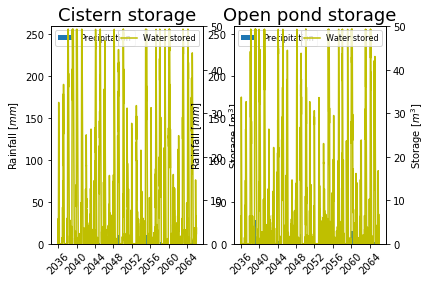

In [33]:
WHSplot(prec_data, output_cis.storage, output_op.storage, Time)

# Automating the script

Generate the following information for at least 5 model runs with different values for the capacity of the reservoir (both pond and cistern): The total costs of investment and maintenance per m3​ of extracted water and the percentage of the days of the period the system contains water. Plot these results in a graph for each WHS on the y- and x-axis respectively. If you want to do this in Python you can use, duplicate and fill in lines after assignment 6 in the script.

In [34]:
# Make for the climate scenario the script available with completed run calculations and plots
run1_cis = storage_calc(prec_data, evap_TW, "cistern", 25, 300, 2, 150, 0)
run2_cis = storage_calc(prec_data, evap_TW, "cistern", 50, 300, 2, 150, 0)
run3_cis = storage_calc(prec_data, evap_TW, "cistern", 75, 300, 2, 150, 0)
run4_cis = storage_calc(prec_data, evap_TW, "cistern", 100, 300, 2, 150, 0)
run5_cis = storage_calc(prec_data, evap_TW, "cistern", 150, 300, 2, 150, 0)

effect1_cis = np.sum(run1_cis.usage) / (len(run1_cis.usage) * potential_usage)
effect2_cis = np.sum(run2_cis.usage) / (len(run2_cis.usage) * potential_usage)
effect3_cis = np.sum(run3_cis.usage) / (len(run3_cis.usage) * potential_usage)
effect4_cis = np.sum(run4_cis.usage) / (len(run4_cis.usage) * potential_usage)
effect5_cis = np.sum(run5_cis.usage) / (len(run5_cis.usage) * potential_usage)

costs1_cis = 32.28 * 25 / np.sum(run1_cis.usage)
costs2_cis = 32.28 * 50 / np.sum(run2_cis.usage)
costs3_cis = 32.28 * 75 / np.sum(run3_cis.usage)
costs4_cis = 32.28 * 100 / np.sum(run4_cis.usage)
costs5_cis = 32.28 * 150 / np.sum(run5_cis.usage)

effectiveness_cis_list = [effect1_cis, effect2_cis, effect3_cis, effect4_cis,
                          effect5_cis]
costs_cis_list = [costs1_cis, costs2_cis, costs3_cis, costs4_cis, costs5_cis]

run1_op = storage_calc(prec_data, evap_TW, "open pond", 25, 300, 2, 150, 0)
run2_op = storage_calc(prec_data, evap_TW, "open pond", 50, 300, 2, 150, 0)
run3_op = storage_calc(prec_data, evap_TW, "open pond", 75, 300, 2, 150, 0)
run4_op = storage_calc(prec_data, evap_TW, "open pond", 100, 300, 2, 150, 0)
run5_op = storage_calc(prec_data, evap_TW, "open pond", 150, 300, 2, 150, 0)

effect1_op = np.sum(run1_op.usage) / (len(run1_op.usage) * potential_usage)
effect2_op = np.sum(run2_op.usage) / (len(run2_op.usage) * potential_usage)
effect3_op = np.sum(run3_op.usage) / (len(run3_op.usage) * potential_usage)
effect4_op = np.sum(run4_op.usage) / (len(run4_op.usage) * potential_usage)
effect5_op = np.sum(run5_op.usage) / (len(run5_op.usage) * potential_usage)

costs1_op = 32.28 * 25 / np.sum(run1_op.usage)
costs2_op = 32.28 * 50 / np.sum(run2_op.usage)
costs3_op = 32.28 * 75 / np.sum(run3_op.usage)
costs4_op = 32.28 * 100 / np.sum(run4_op.usage)
costs5_op = 32.28 * 150 / np.sum(run5_op.usage)

effectiveness_op_list = [effect1_op, effect2_op, effect3_op, effect4_op,
                          effect5_op]
costs_op_list = [costs1_op, costs2_op, costs3_op, costs4_op, costs5_op]

In [35]:
print('\nEffectivness cistern run 1: %s' % effect1_cis)
print('Effectivness cistern run 2: %s' % effect2_cis)
print('Effectivness cistern run 3: %s' % effect3_cis)
print('Effectivness cistern run 4: %s' % effect4_cis)
print('Effectivness cistern run 5: %s\n' % effect5_cis)

print('Costs/$m^3$ cistern run 1: %s' % costs1_cis)
print('Costs/$m^3$ cistern run 2: %s' % costs2_cis)
print('Costs/$m^3$ cistern run 3: %s' % costs3_cis)
print('Costs/$m^3$ cistern run 4: %s' % costs4_cis)
print('Costs/$m^3$ cistern run 5: %s\n' % costs5_cis)

print('Effectivness open pond run 1: %s' % effect1_op)
print('Effectivness open pond run 2: %s' % effect2_op)
print('Effectivness open pond run 3: %s' % effect3_op)
print('Effectivness open pond run 4: %s' % effect4_op)
print('Effectivness open pond run 5: %s\n' % effect5_op)

print('Costs/$m^3$ open pond run 1: %s' % costs1_op)
print('Costs/$m^3$ open pond run 2: %s' % costs2_op)
print('Costs/$m^3$ open pond run 3: %s' % costs3_op)
print('Costs/$m^3$ open pond run 4: %s' % costs4_op)
print('Costs/$m^3$ open pond run 5: %s' % costs5_op)


Effectivness cistern run 1: 0.38182417596375257
Effectivness cistern run 2: 0.4441668704449945
Effectivness cistern run 3: 0.48157366366697585
Effectivness cistern run 4: 0.5025181398757538
Effectivness cistern run 5: 0.5157915168718975

Costs/$m^3$ cistern run 1: 0.2711177663136446
Costs/$m^3$ cistern run 2: 0.466128046011754
Costs/$m^3$ cistern run 3: 0.644881513600135
Costs/$m^3$ cistern run 4: 0.8240046238922675
Costs/$m^3$ cistern run 5: 1.2041995379022574

Effectivness open pond run 1: 0.2815099796231681
Effectivness open pond run 2: 0.3157590832941718
Effectivness open pond run 3: 0.3367424919826039
Effectivness open pond run 4: 0.3525066072775501
Effectivness open pond run 5: 0.3723884090870947

Costs/$m^3$ open pond run 1: 0.36772876702421886
Costs/$m^3$ open pond run 2: 0.6556854462070913
Costs/$m^3$ open pond run 3: 0.9222416550613551
Costs/$m^3$ open pond run 4: 1.1746652751996045
Costs/$m^3$ open pond run 5: 1.6679249168729524


In [36]:
def assignment6plot(x, y, WHS):
    plt.scatter(x, y)
    plt.xlabel('Effectiveness')
    plt.ylabel('Costs [$m^3$]')
    plt.title(WHS)
    plt.show()

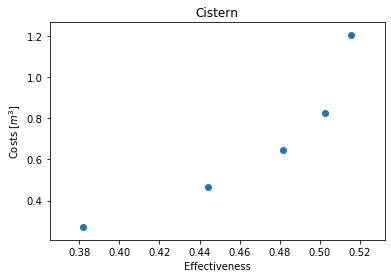

In [37]:
assignment6plot(effectiveness_cis_list, costs_cis_list, "Cistern")

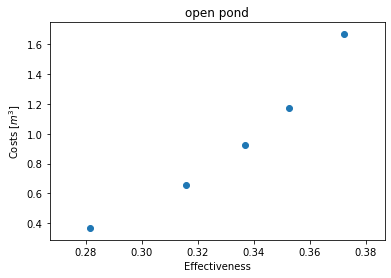

In [38]:
assignment6plot(effectiveness_op_list, costs_op_list, "open pond")